---
title: Multi-Modal Tutorial Co3O4-Mn3O4
numbering:
  enumerator: 5.%s
jupytext:
  formats: md:myst
  text_representation:
    extension: .md
    format_name: myst
kernelspec:
  display_name: Python 3
  language: python
  name: python3
---
### Guided Computation of Fused Multi-Modal Electron Microscopy

+++ {"part": "Code Walkthrough"} 
This tutorial is almost identical to the previous, but now we use a new Co$_3$O$_4$-Mn$_3$O$_4$ dataset which utilizes EELS instead of EDX. We also read from a .h5 file in a similar fashion to how one would read from a .dm3, .dm4, or .emd file format. The parameters for convergence have also changed slightly, highlighting how one set of weights may not work across datasets, hence assessing cost function convergence and regularization weighting is key. Just like the previous dataset, dramatic improvement in image quality is observed within just a few minutes of parameter tuning as seen in Figure 5.1
+++

:::{figure} ./figs/Figure_6_Output_2.png
:name: Raw vs Fused Co$_3$O$_4$-Mn$_3$O$_4$
:width: 700px
Comparison of raw input vs fused multi-modal Co$_3$O$_4$-Mn$_3$O$_4$ HAADF elastic and EDX inelastic images
:::

```{warning} Step 0: Experimental Requirements
To reconstruct using fused multi-modal electron microscopy you need to collect both elastic (e.g. HAADF) and inelastic (e.g. EELS / EDX) maps of your material. For the elastic signal, it is important that it provides Z-contrast of your elements. For the inelastic signal, you should have all chemistries in your sample mapped. Solving for under-determined chemical maps, or using difficult to interpret elastic signals is outside the scope of this tutorial.
```

```{admonition} Step 1
Python Imports
```

In [2]:
import data.fusion_utils as utils
from scipy.sparse import spdiags
import matplotlib.pyplot as plt
from tqdm import tqdm 
import numpy as np
import h5py

```{admonition} Step 2
For this example, the dataset is stored in a .h5 file so this is how you can extract data and then save it numpy arrays for the fused multi-modal workflow.
```

In [20]:
data = 'data/Co3O4_Mn3O4.h5'

# Define element names and their atomic weights
elem_names=['Co', 'Mn', 'O']
elem_weights=[27,25,8]
# Parse elastic HAADF data and inelastic chemical maps based on element index from line above
with h5py.File(data, 'r') as h5_file:
    HAADF = np.array(h5_file['HAADF'])
xx = np.array([],dtype=np.float32)
for ee in elem_names:
	# Read chemical maps
    with h5py.File(data, 'r') as h5_file:
        chemMap = np.array(h5_file[ee])
        
  # Check if chemMap has the same dimensions as HAADF
    if chemMap.shape != HAADF.shape:
        raise ValueError(f"The dimensions of {ee} chemical map do not match HAADF dimensions.")
    # Set Noise Floor to Zero and Normalize Chemical Maps
    chemMap -= np.min(chemMap); chemMap /= np.max(chemMap)
    # Concatenate Chemical Map to Variable of Interest
    xx = np.concatenate([xx,chemMap.flatten()])

```{admonition} Step 3
Reshape your data
```

```{danger} Caution!
Do not change the code below.
```

In [22]:
# Make Copy of Raw Measurements for Poisson Maximum Likelihood Term 
xx0 = xx.copy()

# Incoherent linear imaging for elastic scattering scales with atomic number Z raised to γ  ∈ [1.4, 2]
gamma = 1.6 

# Image Dimensions
(nx, ny) = chemMap.shape; nPix = nx * ny
nz = len(elem_names)

# C++ TV Min Regularizers
reg = utils.tvlib(nx,ny)

# Data Subtraction and Normalization 
HAADF -= np.min(HAADF); HAADF /= np.max(HAADF)
HAADF=HAADF.flatten()

# Create Summation Matrix
A = utils.create_weighted_measurement_matrix(nx,ny,nz,elem_weights,gamma,1)

```{admonition} Optional
:class: tip 
Plot your raw elastic/inelastic data
```

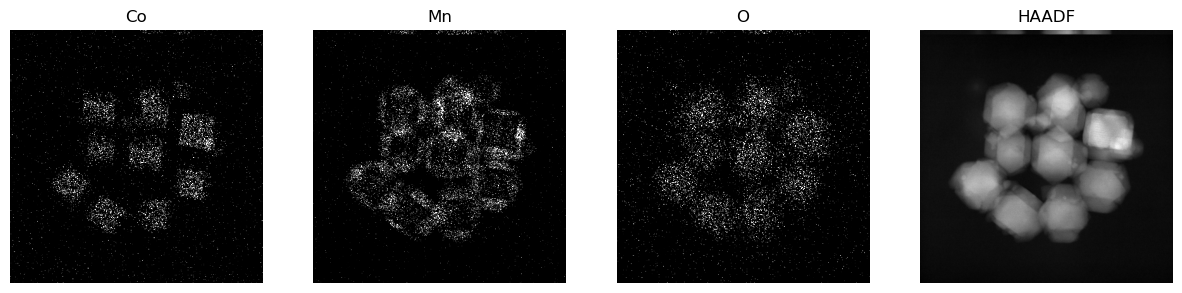

In [24]:
fig, ax = plt.subplots(1, nz + 1, figsize=(15, 8))  # Updated to accommodate an additional subplot for HAADF
ax = ax.flatten()

for ii in range(nz):
    ax[ii].imshow(xx0[ii*(nx*ny):(ii+1)*(nx*ny)].reshape(nx, ny), cmap='gray', vmax=0.3)
    ax[ii].set_title(elem_names[ii])
    ax[ii].axis('off')

ax[nz].imshow(HAADF.reshape(nx, ny), cmap='gray')
ax[nz].set_title('HAADF')
ax[nz].axis('off')

plt.show()

```{admonition} Step 4
Fine tune your weights for each of the three parts of the cost function.
```

In [26]:
# Convergence Parameters
lambdaHAADF = 1/nz # Do not modify this
lambdaChem = 1e-3
nIter = 30 # Typically 10-15 will suffice
lambdaTV = 0.006; #Typically between 0.001 and 1
bkg = 1e-8

# FGP TV Parameters
regularize = True; nIter_TV = 5; 

```{admonition} Step 5
Run the Fused Multi-Modal algorithm. Here an extra line was added to subtract off some of the constant background noise.  This can be helpful when inelastic maps are exceptionally noisy.  The ideal value to background subtract off was found by looking at the mean value of the image found in regions of the image where clear material structure was not present
```

```{danger} Caution!
Do not change the code below.
```

In [28]:
# xx represents the flattened 1D elastic maps we are trying to improve via the cost function
xx = xx0.copy()

# Background noise subtraction for improved convergence
xx = np.where((xx < .2), 0, xx)

# Auxiliary Functions for measuring the cost functions
lsqFun = lambda inData : 0.5 * np.linalg.norm(A.dot(inData**gamma) - HAADF) **2
poissonFun = lambda inData : np.sum(xx0 * np.log(inData + 1e-8) - inData)

# Main Loop

# Initialize the three cost functions components 
costHAADF = np.zeros(nIter,dtype=np.float32); costChem = np.zeros(nIter, dtype=np.float32); costTV = np.zeros(nIter, dtype=np.float32);

for kk in tqdm(range(nIter)):
	# Solve for the first two optimization functions $\Psi_1$ and $\Psi_2$
	xx -=  gamma * spdiags(xx**(gamma - 1), [0], nz*nx*ny, nz*nx*ny) * lambdaHAADF * A.transpose() * (A.dot(xx**gamma) - HAADF) + lambdaChem * (1 - xx0 / (xx + bkg))

	# Enforce positivity constraint
	xx[xx<0] = 0

	# FGP Regularization if turned on
	if regularize:
		for zz in range(nz):
			xx[zz*nPix:(zz+1)*nPix] = reg.fgp_tv( xx[zz*nPix:(zz+1)*nPix].reshape(nx,ny), lambdaTV, nIter_TV).flatten()

			# Measure TV Cost Function
			costTV[kk] += reg.tv( xx[zz*nPix:(zz+1)*nPix].reshape(nx,ny) )
			
	# Measure $\Psi_1$ and $\Psi_2$ Cost Functions
	costHAADF[kk] = lsqFun(xx); costChem[kk] = poissonFun(xx)

100%|███████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.21it/s]


```{admonition} Step 6
Assess convergence by confirming that all 3 cost functions asymptotically approach a low value.
```
```{admonition} Be careful with $\lambda_{TV}$!
:class: attention
```

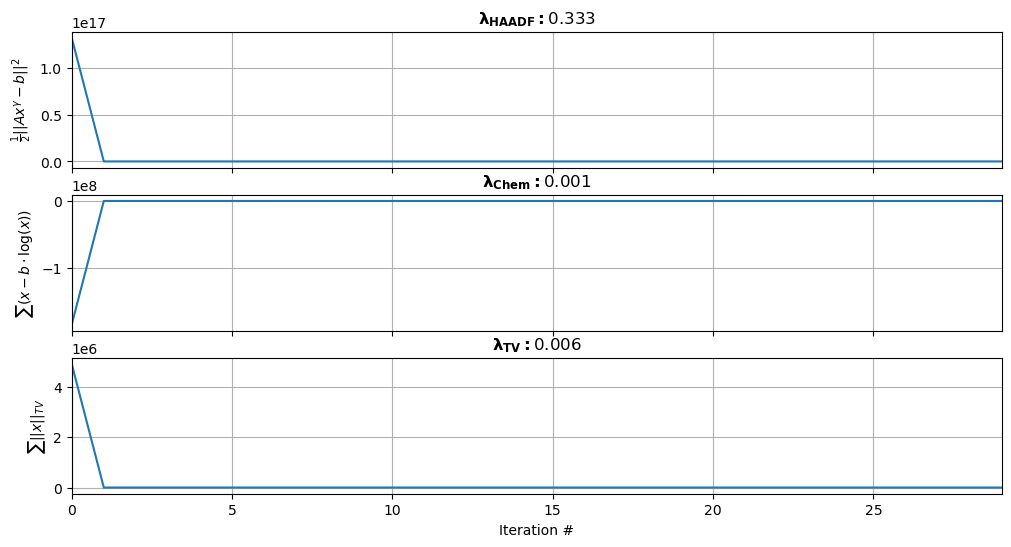

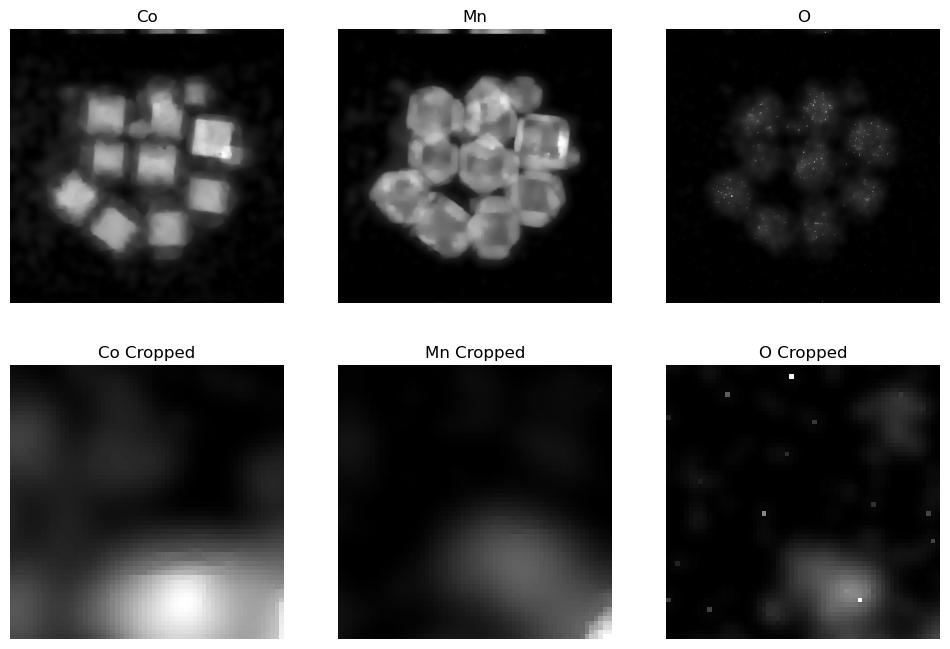

In [30]:
# Display Cost Functions and Descent Parameters
utils.plot_convergence(costHAADF, lambdaHAADF, costChem, lambdaChem, costTV, lambdaTV)
# Show Reconstructed Signal
fig, ax = plt.subplots(2, len(elem_names), figsize=(12, 8))
ax = ax.flatten()

for ii in range(len(elem_names)):
    ax[ii].imshow(xx[ii*(nx*ny):(ii+1)*(nx*ny)].reshape(nx, ny), cmap='gray')
    ax[ii].set_title(elem_names[ii])
    ax[ii].axis('off')
    
    ax[ii + len(elem_names)].imshow(xx[ii*(nx*ny):(ii+1)*(nx*ny)].reshape(nx, ny)[40:100, 50:110], cmap='gray')
    ax[ii + len(elem_names)].set_title(elem_names[ii] + ' Cropped')
    ax[ii + len(elem_names)].axis('off')

plt.show()

```{admonition} Step 7
Save your data
```

In [32]:
save_folder_name='test'
utils.save_data(save_folder_name, xx0, xx, HAADF, A.dot(xx**gamma), elem_names, nx, ny, costHAADF, costChem, costTV, lambdaHAADF, lambdaChem, lambdaTV, gamma)

FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = 'test/Fused_Reconstruction.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)